In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_data.csv', index_col = 0)

# Drop columns with NaN
df = df.dropna(axis=1,how='any')

if False:
    # Turn confusing index string into a unique hash, and drop the string
    # (NOT USED FOR NOW.. )
    import hashlib
    def _my_hash(s):
        return int(
            hashlib.sha256(s.encode('utf-8')).hexdigest(), 16
        ) % 10**12
    hash_list = [_my_hash(val) for val in df.index]
    df['unique_hash'] = hash_list
    df.reset_index(drop=True, inplace=True)
    df = df.set_index('unique_hash')
else:
    df.reset_index(drop=True, inplace=True)

df.head()

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,single_precision_fu_utilization,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,architecture,application_name,input
0,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002058,0.000000,0.000000,0.0,0.0,...,2,1,0.0,0.000000,0.047434,0,1,P100,backprop,-100000_bpnn_adjust_weights_cuda
1,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.000633,0.645833,0.696429,0.0,0.0,...,6,0,0.0,0.004695,0.000000,0,1,P100,backprop,-100000_bpnn_layerforward_CUDA
2,56.00560,bpnn_adjust_weights_cuda,1.0,0.999950,0.999948,0.016234,0.000000,0.000000,0.0,0.0,...,3,2,0.0,0.000000,0.043993,0,1,P100,backprop,-10000_bpnn_adjust_weights_cuda
3,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.006918,0.645833,0.696429,0.0,0.0,...,6,0,0.0,0.003017,0.000000,0,1,P100,backprop,-10000_bpnn_layerforward_CUDA
4,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002492,0.000000,0.000000,0.0,0.0,...,2,1,0.0,0.000000,0.048306,0,1,P100,backprop,-100016_bpnn_adjust_weights_cuda


In [4]:
# Define peak memory bandwidth p100 732
peak_mem_bw = {
    "V100": 898.048 * (1024*1024*1024),
    "P100": 749.0 * (1024*1024*1024),
}
mem_bw_thresh = 0.75

# Add a column specifying if the case is memory bound
df_archs = []
for arch in peak_mem_bw.keys():
    df_tmp = df[df["architecture"] == arch].copy()
    new_col = (
        df_tmp["dram_read_throughput"] + df_tmp["dram_write_throughput"]
    ) / peak_mem_bw[arch]
    new_col = new_col > mem_bw_thresh
    df_tmp["memory_bound"] = new_col
    df_archs.append(df_tmp.copy())
df_merged = pd.concat(df_archs).sort_index()
df_merged.head()

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,architecture,application_name,input,memory_bound
0,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002058,0.000000,0.000000,0.0,0.0,...,1,0.0,0.000000,0.047434,0,1,P100,backprop,-100000_bpnn_adjust_weights_cuda,False
1,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.000633,0.645833,0.696429,0.0,0.0,...,0,0.0,0.004695,0.000000,0,1,P100,backprop,-100000_bpnn_layerforward_CUDA,False
2,56.00560,bpnn_adjust_weights_cuda,1.0,0.999950,0.999948,0.016234,0.000000,0.000000,0.0,0.0,...,2,0.0,0.000000,0.043993,0,1,P100,backprop,-10000_bpnn_adjust_weights_cuda,False
3,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.006918,0.645833,0.696429,0.0,0.0,...,0,0.0,0.003017,0.000000,0,1,P100,backprop,-10000_bpnn_layerforward_CUDA,False
4,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002492,0.000000,0.000000,0.0,0.0,...,1,0.0,0.000000,0.048306,0,1,P100,backprop,-100016_bpnn_adjust_weights_cuda,False


In [5]:
# Convert bool "memory_bound" column to integers
df_merged["memory_bound"]= df_merged["memory_bound"].astype('int')


In [6]:
max_read = df_merged[df_merged['architecture'] == 'V100']['dram_read_throughput'].max()/(1024*1024*1024)
max_write = df_merged[df_merged['architecture'] == 'V100']['dram_write_throughput'].max()/(1024*1024*1024)
read_write = max_read + max_write
print("max read", max_read)
print("max write", max_write)
print("read + write", read_write)
print("usage percentage", read_write/500)

max read 681.512
max write 541.389
read + write 1222.9009999999998
usage percentage 2.4458019999999996


In [7]:
cols = ['dram_read_throughput', 'dram_write_throughput', 'application_name']

base = 'V100'
other = 'P100'


unique_col = [] #column that has matches of kernels run on both architectures
for k, i in zip(df_merged['kernelname'].values, df_merged['input'].values):
    unique_col.append(k+'_'+i)
    
df_merged['unique_index'] = unique_col
df_merged.set_index('unique_index', inplace=True)



df_b = df_merged[df_merged['architecture'] == base].copy()
df_b = df_b[df_b['memory_bound'] == 1][cols]
#df_b = df_b[cols]

df_o = df_merged[df_merged['architecture'] == other].copy()[cols]

df_joined = df_b.join(df_o, lsuffix='_'+base, rsuffix='_'+other) #v100 are memory bound

In [8]:
unique_col.count('N22_mergeSortFirst')

0

In [17]:
ind_check = df_joined[df_joined['application_name_V100'] == 'srad'].index.values
ind_check

array(['compress_v1_compress', 'prepare_v1_prepare', 'srad2_v1_srad2'],
      dtype=object)

In [1]:
"""
for ind in ind_check:
    print(len(df_merged.loc[ind]))
    # Printout should be lots of '2's if there are matches
"""

"\nfor ind in ind_check:\n    print(len(df_merged.loc[ind]))\n    # Printout should be lots of '2's if there are matches\n"

## Memory Bound cross over analysis
Graph below shows the applications that go to being compute bound on the V100. Shoes that these apps have a significant 
increase in write and read throughput 

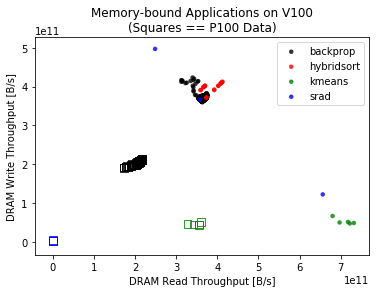

In [423]:
import matplotlib.pyplot as plt

colors = ("black", "red", "green", "blue")
groups = ('backprop', 'hybridsort', 'kmeans', 'srad')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for arch in ['_V100', '_P100']:
    for color, group in zip(colors, groups):

        dft = df_joined[df_joined['application_name'+arch] == group]    
        x = dft['dram_read_throughput'+arch].values
        y = dft['dram_write_throughput'+arch].values
        if arch == '_V100':
            ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=20, marker='o', label=group)
        else:
            ax.scatter(x, y, alpha=0.8, c='none', edgecolors=color, s=60, marker='s')

plt.title('Memory-bound Applications on V100\n(Squares == P100 Data)')
plt.xlabel('DRAM Read Throughput [B/s]')
plt.ylabel('DRAM Write Throughput [B/s]')
plt.legend(loc='best')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [ ]:
# get p100 kernels that don't become memory bound - randomly sample no's plot them
# plot the ones that don't become memory bound - how would they look - are the yes's and no's mixed in - 
# all the ones in a region 
# pick values from p100 squares, use model to predict them, plot results in graph, does it keep the trend

In [ ]:
# leave out dram read and write and figure if other metrics give you same trend
# just do it for p100 

## Trying to look at memory bound vs IPC

In [ ]:
cols = ['dram_read_throughput', 'dram_write_throughput', 'ipc', 'application_name']

base = 'V100'
other = 'P100'


unique_col = [] #column that has matches of kernels run on both architectures
for k, i in zip(df_merged['kernelname'].values, df_merged['input'].values):
    unique_col.append(k+'_'+i)
    
df_merged['unique_index'] = unique_col
df_merged.set_index('unique_index', inplace=True)



df_b = df_merged[df_merged['architecture'] == base].copy()
df_b = df_b[df_b['memory_bound'] == 1][cols]
#df_b = df_b[cols]

df_o = df_merged[df_merged['architecture'] == other].copy()[cols]

df_joined = df_b.join(df_o, lsuffix='_'+base, rsuffix='_'+other) #v100 are memory bound

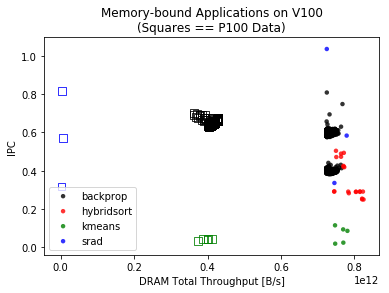

,dram_read_throughput_V100,dram_write_throughput_V100,ipc_V100,application_name_V100,dram_read_throughput_P100,dram_write_throughput_P100,ipc_P100,application_name_P100
unique_index,,,,,,,,
invert_mapping_N10000000_invert_mapping,6.970259e+11,5.069285e+10,0.019411,kmeans,3.273076e+11,4.603840e+10,0.033223,kmeans
invert_mapping_N1000000_invert_mapping,7.317679e+11,4.927713e+10,0.086208,kmeans,3.553108e+11,4.532844e+10,0.042375,kmeans
invert_mapping_N100000_invert_mapping,6.800232e+11,6.729355e+10,0.115199,kmeans,3.605271e+11,5.142633e+10,0.043656,kmeans
invert_mapping_N3000000_invert_mapping,7.217800e+11,4.813424e+10,0.024758,kmeans,3.550553e+11,4.481487e+10,0.041753,kmeans
invert_mapping_N300000_invert_mapping,7.174303e+11,5.203578e+10,0.093966,kmeans,3.422670e+11,4.559527e+10,0.043771,kmeans


In [162]:
import matplotlib.pyplot as plt

colors = ("black", "red", "green", "blue")
groups = ('backprop', 'hybridsort', 'kmeans', 'srad')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for arch in ['_V100', '_P100']:
    for color, group in zip(colors, groups):

        dft = df_joined[df_joined['application_name'+arch] == group]
        
        if arch == '_P100' and group == "kmeans":
            dft_show = dft.copy()
        
        x = dft['dram_read_throughput'+arch].values + dft['dram_write_throughput'+arch].values
        y = dft['ipc'+arch].values
        if arch == '_V100':
            ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=20, marker='o', label=group)
        else:
            ax.scatter(x, y, alpha=0.8, c='none', edgecolors=color, s=60, marker='s')

plt.title('Memory-bound Applications on V100\n(Squares == P100 Data)')
plt.xlabel('DRAM Total Throughput [B/s]')
plt.ylabel('IPC')
plt.legend(loc='best')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()
dft_show

In [122]:
df_merged.loc['srad2_v1_srad2']['dram_read_throughput']

unique_index
srad2_v1_srad2    0.000000e+00
srad2_v1_srad2    6.561518e+11
Name: dram_read_throughput, dtype: float64

In [137]:
df_P100 = df_merged[df_merged['architecture'] == 'P100']

all_memory_bond = df_merged[df_merged["memory_bound"] == 1]
all_memory_bond[all_memory_bond["kernelname"] == "invert_mapping"]
#all_memory_bond

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,architecture,application_name,input,memory_bound
unique_index,,,,,,,,,,,,,,,,,,,,,
invert_mapping_N10000000_invert_mapping,925.210320,invert_mapping,0.999999,0.999998,0.959966,0.000939,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0,1,V100,kmeans,N10000000_invert_mapping,1
invert_mapping_N1000000_invert_mapping,915.276896,invert_mapping,1.000000,1.000000,0.959961,0.001204,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0,1,V100,kmeans,N1000000_invert_mapping,1
invert_mapping_N100000_invert_mapping,908.656250,invert_mapping,1.000000,1.000000,0.959957,0.008191,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0,1,V100,kmeans,N100000_invert_mapping,1
invert_mapping_N3000000_invert_mapping,917.146368,invert_mapping,1.000000,1.000000,0.959963,0.001063,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0,1,V100,kmeans,N3000000_invert_mapping,1
invert_mapping_N300000_invert_mapping,891.357143,invert_mapping,1.000000,1.000000,0.959946,0.002369,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0,1,V100,kmeans,N300000_invert_mapping,1


In [138]:
#scaling df_merged
from sklearn.preprocessing import StandardScaler

# User specified
drop_cols = ['architecture','input','application_name','kernelname','memory_bound']

# Automatically detect non numerical columns
for col in df_merged:
    if df_merged[col].dtype == 'object':
        drop_cols.append(col)
        
# Convert numerical columns to out training/test
data_to_scale = df_merged.drop(drop_cols, axis=1).values
scaler = StandardScaler().fit(data_to_scale)
scaled_data_ = scaler.transform(data_to_scale)



In [173]:
##df_P100 = df_merged[df_merged['architecture'] == 'V100']
##membound_kernels = df_P100[df_P100['memory_bound']==1]
##spec_kernels = membound_kernels[membound_kernels['kernelname']=='mergeSortFirst']
srad_val1 = scaled_data_[df_P100.index.get_loc('prepare_v1_prepare')]
srad_val2 = scaled_data_[df_P100.index.get_loc('compress_v1_compress')]
srad_val3 = scaled_data_[df_P100.index.get_loc('srad2_v1_srad2')]

kmeans_val1 = scaled_data_[df_P100.index.get_loc('invert_mapping_N10000000_invert_mapping')]
kmeans_val2 = scaled_data_[df_P100.index.get_loc('invert_mapping_N1000000_invert_mapping')]
kmeans_val3 = scaled_data_[df_P100.index.get_loc('invert_mapping_N100000_invert_mapping')]
kmeans_val4 = scaled_data_[df_P100.index.get_loc('invert_mapping_N3000000_invert_mapping')]
kmeans_val5 = scaled_data_[df_P100.index.get_loc('invert_mapping_N300000_invert_mapping')]

#df_P100.index.get_loc(spec_kernels)

# srad points that become memory bound in v100
"""
prepare_v1_prepare
compress_v1_compress
srad2_v1_srad2
"""

'\nprepare_v1_prepare\ncompress_v1_compress\nsrad2_v1_srad2\n'

In [174]:
print(srad_val1.shape)
srad_val1 = srad_val1.reshape(1,116)
srad_val2 = srad_val2.reshape(1,116)
srad_val3 = srad_val3.reshape(1,116)

kmeans_val1 = kmeans_val1.reshape(1,116)
kmeans_val2 = kmeans_val2.reshape(1,116)
kmeans_val3 = kmeans_val3.reshape(1,116)
kmeans_val4 = kmeans_val4.reshape(1,116)
kmeans_val5 = kmeans_val5.reshape(1,116)

(116,)


## Loading deep learning model

In [101]:
from keras.models import load_model
##weighted mse
import keras.backend as K
def weighted_mse(loss_weight):
    def loss(y_true, y_pred):
        #import pdb; pdb.set_trace()
        #y_true = K.variable(y_true)
        #y_pred = K.variable(y_pred)
        #loss = K.mean(K.dot(K.square(y_true - y_pred),loss_weight))
        loss = K.mean(K.square(y_true - y_pred)*loss_weight)
        return loss

    return loss
loss_weight = np.ones(116)
loss_weight[96] = 100#17
loss_weight[33] = 1#15
loss_weight[34] = 1#14
loss_weight[105] = 1#13
loss_weight[106] = 1#10
model_10 = load_model('bslh_DL_wbias.h5',custom_objects={'loss': weighted_mse(loss_weight)})

In [175]:
y_pred1 = model_10.predict(srad_val1)
y_pred2 = model_10.predict(srad_val2)
y_pred3 = model_10.predict(srad_val3)

y_pred4 = model_10.predict(kmeans_val1)
y_pred5 = model_10.predict(kmeans_val2)
y_pred6 = model_10.predict(kmeans_val3)
y_pred7 = model_10.predict(kmeans_val4)
y_pred8 = model_10.predict(kmeans_val5)

all_pred = [y_pred4,y_pred5,y_pred6,y_pred7,y_pred8]

In [176]:
#lined up because they all meet up threshold 

In [182]:
check = ['dram_read_throughput', 'dram_write_throughput']

for metric in check:
    val = y_pred8[:,df_P100.columns.get_loc(metric)]
    print(metric, val)

dram_read_throughput [0.03750064]
dram_write_throughput [0.15032607]


## Need to plot predicted results alongside true results - can we capture the same trend

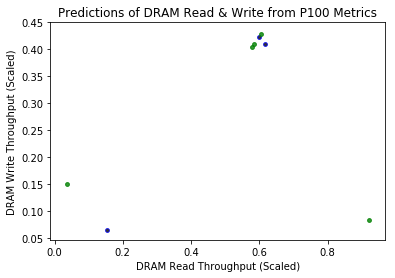

In [184]:
import matplotlib.pyplot as plt

colors = ("black", "red", "green", "blue")
groups = ('backprop', 'hybridsort', 'kmeans', 'srad')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(0.60036594, 0.42199054, alpha=0.8, c="black", edgecolors="blue", s=60, marker='.')
ax.scatter(0.616695, 0.40840748, alpha=0.8, c="black", edgecolors="blue", s=60, marker='.')
ax.scatter(0.15512206, 0.06506637, alpha=0.8, c="black", edgecolors="blue", s=60, marker='.')

ax.scatter(0.9213409, 0.08370703, alpha=0.8, c="green", edgecolors="green", s=60, marker='.')
ax.scatter(0.60343444, 0.42702377, alpha=0.8, c="green", edgecolors="green", s=60, marker='.')
ax.scatter(0.57866484, 0.40426365, alpha=0.8, c="green", edgecolors="green", s=60, marker='.')
ax.scatter(0.5838182, 0.40979192, alpha=0.8, c="green", edgecolors="green", s=60, marker='.')
ax.scatter(0.03750064, 0.15032607, alpha=0.8, c="green", edgecolors="green", s=60, marker='.')


plt.title('Predictions of DRAM Read & Write from P100 Metrics')
plt.xlabel('DRAM Read Throughput (Scaled)')
plt.ylabel('DRAM Write Throughput (Scaled)')
plt.show()

In [ ]:
# TODO - put in scaled true metrics 

## Random Forest model used below to predict whether app becomes memory bound

In [113]:
cols_other_keep = ['memory_bound']

base = 'P100' #metrics
other = 'V100' #labels


unique_col = [] #column that has matches of kernels run on both architectures
for k, i in zip(df_merged['kernelname'].values, df_merged['input'].values):
    unique_col.append(k+'_'+i)
df_merged['unique_index'] = unique_col
df_merged.set_index('unique_index', inplace=True)


df_b = df_merged[df_merged['architecture'] == base].copy().drop(cols_other_keep, axis=1)

df_o = df_merged[df_merged['architecture'] == other].copy()[cols_other_keep]

df_p_to_v = df_b.join(df_o, lsuffix='_'+base, rsuffix='_'+other)
df_p_to_v = df_p_to_v.dropna(axis=0,how='any')
# 57 - flop_count_sp_special
# 22 - dram_read_transactions
# 47 - gst_efficiency
# 16 - gld_transactions
# 88 - l2_tex_read_transactions
##df_p_to_v.iloc[:,88]

In [384]:
# Results of applications that are memory bound
df_v100_temp = df_merged[df_merged['architecture'] == 'V100']
df_p100_temp = df_merged[df_merged['architecture'] == 'P100']

df_v100_temp = df_v100_temp[df_v100_temp['memory_bound']==1]
#print(df_v100_temp.head)
df_p100_temp[df_p100_temp['application_name'] == 'hybridsort']

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,architecture,application_name,input,memory_bound
unique_index,,,,,,,,,,,,,,,,,,,,,
bucketcount_N100_bucketcount,653.000000,bucketcount,1.000000,0.936447,0.928024,0.003063,1.058824,1.030303,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_bucketcount,0
bucketprefixoffset_N100_bucketprefixoffset,46.000000,bucketprefixoffset,1.000000,1.000000,0.956521,0.087092,0.000000,0.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_bucketprefixoffset,0
bucketsort_N100_bucketsort,624.000000,bucketsort,1.000000,0.976762,0.971955,0.004904,2.000000,1.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_bucketsort,0
histogram1024Kernel_N100_histogram1024Kernel,403.786458,histogram1024Kernel,0.999781,0.999198,0.989265,0.007502,1.000325,1.000163,0.0,0.0,...,0,0.0,3.000000e-06,0.0,0,1,P100,hybridsort,N100_histogram1024Kernel,0
mergeSortFirst_N100_mergeSortFirst,16.250000,mergeSortFirst,1.000000,0.900000,0.896153,0.184615,0.000000,0.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_mergeSortFirst,0
mergeSortPass_N100_mergeSortPass,71.500000,mergeSortPass,1.000000,0.803534,0.760675,0.028055,0.000000,0.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_mergeSortPass,0
mergepack_N100_mergepack,13.025391,mergepack,1.000000,0.998111,0.998106,0.011334,0.000000,0.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N100_mergepack,0
bucketcount_N101_bucketcount,653.000000,bucketcount,1.000000,1.000000,0.989280,0.003063,1.235294,1.121212,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N101_bucketcount,0
bucketprefixoffset_N101_bucketprefixoffset,46.000000,bucketprefixoffset,1.000000,1.000000,0.956521,0.087120,0.000000,0.000000,0.0,0.0,...,0,0.0,0.000000e+00,0.0,0,1,P100,hybridsort,N101_bucketprefixoffset,0


In [301]:
# Simple analysis 
print("Total memory bound:", sum(df_merged['memory_bound']))
print("Number of data points:", df_merged.shape)
total = sum(df_merged['memory_bound'])
print("percentage memory bound", int(100 *sum(df_merged['memory_bound'])/63466), "%")
print("Number of V100 points", df_merged[df_merged['architecture'] == 'V100'].shape)
print("Number of P100 points", df_merged[df_merged['architecture'] == 'P100'].shape)
p100 = df_merged[df_merged['architecture'] == 'P100']
v100 = df_merged[df_merged['architecture'] == 'V100']
total_p100_mem = sum(p100['memory_bound'])
print("Low memory bw in p100 runs:", total_p100_mem)
total_v100_mem = sum(v100['memory_bound'])
print("Low memory bwin v100 runs:", total_v100_mem)
print("amount of v100", len(v100['memory_bound']))
print("Percentage memory bound in V100",total_v100_mem/len(v100['memory_bound']))
print("Max read through put p100:", (p100['dram_read_throughput'].max())/(1024*1024*1024), "GB/s")
print("Max read through put v100:", (v100['dram_read_throughput'].max())/(1024*1024*1024), "GB/s")

Total memory bound: 2620
Number of data points: (63466, 121)
percentage memory bound 4 %
Number of V100 points (31169, 121)
Number of P100 points (32297, 121)
Low memory bw in p100 runs: 0
Low memory bwin v100 runs: 2620
amount of v100 31169
Percentage memory bound in V100 0.08405787801982739
Max read through put p100: 489.92199999999997 GB/s
Max read through put v100: 681.512 GB/s


In [266]:
# conclude ipc is lower bc so much more pressure in memory system 
# tool that gives a 'shoe' looking ipc - predicting lower than we expect
# why would ipc be lower - memory issues, branch issues, 
# dram and cache performance
# are predicted values following similar trends of shoe representation
"""
applications didn't have parallelism to use them - sm utilization 
cluster analysis on p100 and v100 and see if predictions are the same
which kernels moved clusters? 
what is causing the ipc drop?? memory bound could be 1, what are the others?
p100 - correlated metrics for ipc, are they the same correlations for v100 
find new correlations
slicing out data size - predict large from small (not high priority)
samples that are fast
samples by percentage 
application basis of new architecture
"""
# Save intermediate dataframe to parquet file
#df_merged.to_parquet('df.clean.parquet.gzip', compression='gzip')
df_p_to_v.to_parquet('df_v100_labels.clean.parquet.gzip', compression='gzip')

## How to read it back (very fast), if needed:
#df_merged = pd.read_parquet('df.clean.parquet.gzip')

In [289]:
# Dropping everything not "V100"
df_dataset = df_merged[df_merged['architecture'] == 'V100']

##df_dataset = df_p_to_v.copy()

# Note: To include "P100" and "V100", use `df_dataset = df_merged.copy()`

In [290]:
# List of columns we want to drop...

# User specified
drop_cols = [
    'memory_bound',
    'dram_read_throughput',
    'dram_write_throughput',
]
# Automatically detect non numerical columns
for col in df_dataset:
    if df_dataset[col].dtype == 'object':
        drop_cols.append(col)

In [291]:
# Get prediction target (memory_bound column):
target = df_dataset['memory_bound'].values
        
# Convert numerical columns to out training/test
data = df_dataset.drop(drop_cols, axis=1).values

In [292]:
# Create reandom list of indices
np.random.seed(42)

# Choose fraction of data for training
# (rest will be for tests, for now)
frac_train = 0.7

# Shuffle data using random permutation
ind = np.random.permutation([i for i in range(len(df_dataset.index))])
n_train = int(frac_train * len(df_dataset.index))
n_test = int((1.0 - frac_train) * len(df_dataset.index))

In [293]:
print(n_train)



21818


In [294]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data)
scaled_data = scaler.transform(data)

# Define training set
X_train = scaled_data[ind[:n_train]]
y_train = target[ind[:n_train]]

# Define test set
X_test = scaled_data[ind[n_train:]]
y_test = target[ind[n_train:]]

In [295]:
# Returns a list of weights for the specified dataset
# indices (`indices`), given the parent dataframe (`df`)
# and a dictionary of weights to apply. Application names
# that are not included in `weights` will be set to 1.0
def get_w_vec(df, indices, weights):
    w = []
    for ind in indices:
        default = 1.0
        name = df.iloc[ind]["application_name"]
        w.append(weights.get(name, default))
    return w

train_weights = get_w_vec(
    df_dataset,
    ind[:n_train],
    {
        "backprop": 1.0,
        "srad": 2.0,
    },
)   

In [296]:
print(ind[:n_train])

[ 2885 22535 18823 ... 21846 18029  8012]


In [297]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
w=50 #class weight might improve confusion matrix 
# Create a random forest Classifier. By convention, clf means 'Classifier'
#clf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(
    RandomForestClassifier(n_estimators=100,class_weight={0:1,1:w}),
    param_grid=dict(max_features=[110]),
    scoring='accuracy',
    cv=2
)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 50},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [110]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [317]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, random_state=42, test_size=.33)

In [318]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=1000)
model = clf.fit(X_train, y_train)

In [323]:
from tabulate import tabulate
X_train = pd.DataFrame(X_train)
headers = ["name", "score"]
values = sorted(zip(X_train, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

  name        score
    57  0.101459
    22  0.084635
    47  0.0508194
    16  0.047395
    88  0.0447893
    21  0.0428037
    20  0.0377253
    69  0.0330939
    46  0.0326701
    48  0.0313817
    64  0.0310974
     3  0.0297012
    49  0.0272267
    26  0.0240634
    15  0.0223619
    35  0.0222064
    71  0.0217048
    28  0.0214544
    85  0.0210032
    25  0.0207977
    27  0.0207347
    19  0.0178043
    10  0.0166726
    36  0.0161758
    34  0.015591
   111  0.0149794
    33  0.0127917
    61  0.0113406
    39  0.0105155
    60  0.00837216
    59  0.00579021
    72  0.00453255
    37  0.00446679
    45  0.00416475
    63  0.00412588
    80  0.00402828
    56  0.00398318
    78  0.00398118
    79  0.00378193
    73  0.00377495
    31  0.00368291
    65  0.00366285
    98  0.00352723
    70  0.0033771
    76  0.00328891
    74  0.00322777
    77  0.00295008
    99  0.00280548
    30  0.00248494
    23  0.00240989
    55  0.0024084
    97  0.00239991
    29  0.00231462
    86  

In [ ]:
# 57 - flop_count_sp_special
# 22 - dram_read_transactions
# 47 - gst_efficiency
# 16 - gld_transactions
# 88 - l2_tex_read_transactions

In [298]:
# Simple training-set accuracy calculation
y_test_predict = clf.predict(X_test)

correct = 0
for p, t in zip(y_test_predict, y_test):
    if p == t:
        correct += 1
accuracy = correct / len(y_test)
accuracy

0.9937974548176666

In [299]:
sum(y_test) / len(y_test)

0.08683563255266816

In [280]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_predict)

In [281]:
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
print(cm)

[[0.98678161 0.01321839]
 [0.03705571 0.96294429]]


In [282]:
# all of data results
# 0.9839 is what correctly predicts 1 
# 0.9978609 is what correctl predicts 0
# lasso regression - drives unimportant weights down to zero

In [ ]:
# workflow for predicting whether application will be memory bound on different architecture - 
# figuring out which applications are more likely to be memory bound
# input from one architecture, output for another
# p100 metrics with v100 results

##
"""

hypothesis: Given a model that can predict V100 behavior from P100 data, we would predict that you could reach 
the same conclusions with much less data collection, much less evaluation time.

"""